In [5]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

## allow the import of the MovieData class
import sys
import os
path = os.path.abspath(os.getcwd()) + '/../data_load'
sys.path.insert(0, path)

from movie_data import MovieData

%matplotlib inline

In [6]:
moviedata = MovieData(min_genre_frequency=0.1)
print(moviedata.genre_labels)

['Action' 'Adventure' 'Comedy' 'Crime' 'Drama' 'Horror' 'Romance'
 'Thriller']


In [7]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

# LDA

In [19]:
n_features = 5000
n_top_words = 20

count_vectorizor = CountVectorizer(
        max_df=0.95, 
        min_df=2,
        max_features=n_features,
        stop_words='english'
)
count = count_vectorizor.fit_transform(moviedata.plots)
count_feature_names = count_vectorizor.get_feature_names()

lda = LatentDirichletAllocation(
        n_topics=8, max_iter=15,
        learning_method='online',
        learning_offset=50.,
        random_state=0
)
Z = lda.fit_transform(count)

print_top_words(lda, count_feature_names, n_top_words)

Topic #0:
professor king prince princess invention ma queen oil england throne bennett land lord east coast tournament royal chinese lily pakistan
Topic #1:
new york city family world life story school money young film lives harry team american students ray real follows mind
Topic #2:
earth group evil years human world alien crew planet save ship team son race los angeles help time michael new
Topic #3:
life man young family father old love mother woman story town year years time finds help son daughter home lives
Topic #4:
war police world agent murder group killer drug team american secret mission bond case man fbi detective forces government president
Topic #5:
alex lee danny hannah winter wilderness julie bent guide lion scam pat pearl lizzie rush hughes black hole various irving
Topic #6:
school friends life high friend best love new night day college big movie just sex star gets girl time party
Topic #7:
charlie victor darkness experiments bridge madness wallace matrix exorcism t

# TF-IDF

In [9]:
vectorizer = TfidfVectorizer(
    max_df=0.7, 
    analyzer='word',
    ngram_range=(1, 1),
    max_features=n_features,
    stop_words='english')

X = vectorizer.fit_transform(moviedata.plots)
# vectorizer.get_feature_names()

In [10]:
pca = PCA(n_components=20)
XX = pca.fit_transform(X.todense())

## Combined

In [20]:
combined_features = np.hstack([Z, XX])

X_train, X_test, y_train, y_test = train_test_split(
    combined_features, 
    moviedata.one_hot_genres, 
    test_size=0.4, 
    random_state=42
)

# Linear Regression

In [21]:
genre_coeffs = []
scores = []

for i, label in enumerate(moviedata.genre_labels):
    coeffs = np.linalg.lstsq(X_train, y_train[:, i])[0]
    genre_coeffs.append(coeffs)
    y_pred_probs = np.dot(X_test, coeffs)
    y_pred = np.array(y_pred_probs > 0.25, dtype=int)
    score = f1_score(y_test[:, i], y_pred)
    scores.append(score)
    print("Genre: {}, Score: {:.2f}".format(label, score))
    
print('Mean f1 score: {:.3f}'.format(np.mean(scores)))

Genre: Action, Score: 0.58
Genre: Adventure, Score: 0.51
Genre: Comedy, Score: 0.58
Genre: Crime, Score: 0.53
Genre: Drama, Score: 0.69
Genre: Horror, Score: 0.34
Genre: Romance, Score: 0.51
Genre: Thriller, Score: 0.38
Mean f1 score: 0.517


# Logistic Regression

Genre: Action, Score: 0.59
Genre: Adventure, Score: 0.48
Genre: Comedy, Score: 0.57
Genre: Crime, Score: 0.50
Genre: Drama, Score: 0.65
Genre: Horror, Score: 0.34
Genre: Romance, Score: 0.44
Genre: Thriller, Score: 0.39
Mean f1 score: 0.496


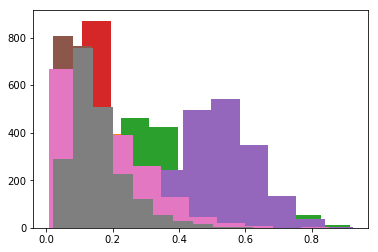

In [22]:
scores = []

for i, label in enumerate(moviedata.genre_labels):
    clf = LogisticRegression()
    clf.fit(X_train, y_train[:, i])
    y_pred_probs = clf.predict_proba(X_test)[:, 1]
    plt.hist(y_pred_probs)
    y_pred = np.array(y_pred_probs > np.mean(y_pred_probs), dtype=int)
    score = f1_score(y_test[:, i], y_pred)
    scores.append(score)
    print("Genre: {}, Score: {:.2f}".format(label, score))
    
print('Mean f1 score: {:.3f}'.format(np.mean(scores)))

# Random Forrest

In [23]:
clf = RandomForestClassifier(n_estimators=25, max_features='auto', max_depth=None)
clf.fit(X_train, y_train)
y_guess_probs = clf.predict_proba(X_test)
y_guess = clf.predict(X_test)

In [24]:
scores = f1_score(y_test, y_guess, average=None)

In [25]:
print(np.mean(scores))

0.33544869369


In [26]:
# guess randomly
np.mean(f1_score(y_test, np.random.randint(0, 2, y_test.shape), average=None))

0.313261197146808